# Finetune a LLM with Synthetic Data

The goal here is to perform LLM fine-tuning with the Mosaic AI Model Training API. We will use the real training data and the synthetuc data.

The steps are:
1. Prepare fine-tuning dataset
2. Perform fine-tuning
3. Serve a fine-tuned LLM on the Databricks Model Serving endpoint for batch evaluation

In [0]:
%pip install databricks-genai mlflow --quiet

dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## Prepare for finetuning

In [0]:
prompt = """You are an AI assistant specialized in analyzing legal contracts. Your task is to extract relevant information from a given contract document to a structured JSON schema.

Instructions:
1. Carefully read the entire contract document provided at the end of this prompt.
2. Extract the relevant information.
3. Present your findings in JSON format as specified below.

Output Format:
- The output response should be valid JSON, enclosed in triple backticks with a JSON tag.
- The output values should be extracted from the contract document directly. They should not be paraphrased or otherwise edited.

Contract to analyze:
{lease}
"""

In [0]:
ft_df = spark.sql(
    """
    -- real training data
    SELECT 
    ARRAY(
        STRUCT('user' AS role, CONCAT('{0}', '\n', lease_doc) AS content),
        STRUCT('assistant' AS role, labels AS content)
    ) AS messages
    FROM dhuang.synthgen.lease_docs_train

    -- union synthetic data
    UNION
    SELECT 
    ARRAY(
        STRUCT('user' AS role, CONCAT('{0}', '\n', lease_doc) AS content),
        STRUCT('assistant' AS role, labels AS content)
    ) AS messages
    FROM dhuang.synthgen.lease_docs_train_synth

    """.format(prompt.replace("'", '"'))
)

display(ft_df.limit(5))

messages List(List(user, You are an AI assistant specialized in analyzing legal contracts. Your task is to extract relevant information from a given contract document to a structured JSON schema.

Instructions:
1. Carefully read the entire contract document provided at the end of this prompt.
2. Extract the relevant information.
3. Present your findings in JSON format as specified below.

Output Format:
- The output response should be valid JSON, enclosed in triple backticks with a JSON tag.
- The output values should be extracted from the contract document directly. They should not be paraphrased or otherwise edited.

Contract to analyze:
{lease}

Exhibit 10.5
Xia (She) 0075213
Contract registration (record) No:
Xiamen Realty Lease Contract
Xiamen Realty Leasing Administrative Office
Realty lease contract
The lessor (party A): Xiamen Chuangyuan Property Management Co., Ltd.
Address: Room 108, West Zone, Financial Centre, Huli District, Xiamen
Postal Code:.
Authorized agent:
Address:
Postal Code:
The renter (party B): Fujian Better Technology Co., Ltd.
Address: Floor 5-8 Building 32, High-tech Industrial Park, Tongan District, Xiamen
Postal Code:
Business License or ID No.:
Authorized agent:
Address:
Postal Code:
Party A and party B discussed and agreed the following terms based on “China Contract Law”, “China Real Estate Administrative Law”, “Xiamen Special Economic Zone House Leasing Act” and achieved this agreement.
Item 1 Party A lease the realty locates at Floor 5-8 Building 32, High-tech Industrial Park, Tongan District, Xiamen (hereinafter called “leased realty”) to party B. The total area of the leased realty is 6,500 m2, in a building of 18 storeys.
The obligee of the leased realty is: Xiamen Chuangyuan Property Management Co., Ltd.;
The property right certification or other effective certification and number of the property right (or right of use): Certification;
Item 2 The leasing price is RMB 18.88 (Eighteen yuan and 88 cents) per m2 per month, and RMB 122,720.00 per month in total.
Item 3 Party B should make the first payment of RMB 122,720.00 by May 1, 2023.
Item 4 Party B should pay rentals to party A before the 8th of every month;
( ) before--date of -- month every quarter;
( ) before--date of -- month every half year;
( ) before--date of -- month every year;
Party A should provide taxation receipt when it receives rentals from party B.
(Please choose one from the above 4 terms.)
Item 5 The lease period is from May 1, 2023 to June 30, 2024.
The above period could not over the land use period. The period over land use period is invalid. Any loss results from over period should obey the terms of agreement between two parties, if there is any; otherwise, will be the responsibility of party A.
Item 6 The purpose of leasing property is for office and research development.
If party B wants to use the leased property for other purpose, it should be approved by party A in written in advance. Party B should also apply to the property administration department for changing the purpose before it is actually changed.
Item 7 Party A should provide the leased realty to party B and conduct the transfer process by May 1, 2023.
In case party A transfers the property to party B later than the above date, party B could require delaying the ending time of the lease period correspondingly. Both parties should sign to confirm and register at the registration office.
Item 8 When hand over the property, both parties should confirm the working condition of all appliances and additions in the property and attaches a list in the agreement.
Item 9 Party A could take 2 months rentals, that is, RMB 245,440.00 (Two hundred forty-five thousand and four hundred forty RMB yuan) from party B as deposit when hand over the property.
Party A should provide receipt to party B when deposit received. Conditions of refunding the deposit:
1. Expiration of the agreement
2. The property was repaired, transfer process completed, without any fees unpaid to 

In [0]:
train_df, eval_df = ft_df.randomSplit([0.8, 0.2], seed=1)

display(train_df.count())
display(eval_df.count())

108

23

In [0]:
train_df.write.format("delta").mode("overwrite").saveAsTable(
    "dhuang.synthgen.ft_training_with_synths"
)

eval_df.write.format("delta").mode("overwrite").saveAsTable(
    "dhuang.synthgen.ft_eval"
)

## Start a finetuning run

In [0]:
import json
import mlflow

mlflow.set_registry_uri("databricks-uc")

base_model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
registered_model_name = "dhuang.synthgen.ft_model_llama3_1_8b"

training_data_path = "dhuang.synthgen.ft_training"
eval_data_path = "dhuang.synthgen.ft_eval"
experiment_path = "/Users/david.huang@databricks.com/synthgen-lease-doc-experiment"
task_type = "CHAT_COMPLETION"
training_duration = "5ep"
current_cluster_id = (
    json.loads(
        dbutils.notebook.entry_point.getDbutils().notebook().getContext().safeToJson()
    )["attributes"]["clusterId"]
)

In [0]:
from databricks.model_training import foundation_model as fm

lr_list = ["1e-6", "2e-6", "3e-6", "4e-6"] # sweep

for learning_rate in lr_list:

    run = fm.create(
        data_prep_cluster_id=current_cluster_id,
        model=base_model_name,  
        train_data_path=training_data_path,
        eval_data_path=eval_data_path,
        task_type=task_type,  
        training_duration=training_duration,
        register_to=registered_model_name,
        learning_rate=learning_rate,
        experiment_path=experiment_path
    )

print(run)

TrainingRun(name='ift-meta-llama-3-1-8b-instruct-yr7wct', status=<RunStatus.PENDING: 'PENDING'>, created_by='david.huang@databricks.com', model='meta-llama/Meta-Llama-3.1-8B-Instruct', save_folder='dbfs:/databricks/mlflow-tracking/{mlflow_experiment_id}/{mlflow_run_id}/artifacts', train_data_path='dhuang.synthgen.ft_training', register_to='dhuang.synthgen.ft_model_llama3_1_8b', submitted_experiment_path='/Users/david.huang@databricks.com/synthgen-lease-doc-experiment', task_type='CHAT_COMPLETION', eval_data_path='dhuang.synthgen.ft_eval', eval_prompts=[], custom_weights_path=None, training_duration='5ep', learning_rate=4e-06, context_length=None, data_prep_cluster_id='0824-142210-ezxbdamz', details='The service is currently experiencing high demand. Your run will start as soon as compute becomes available.', created_at=datetime.datetime(2024, 11, 11, 6, 39, 59, 268000, tzinfo=datetime.timezone.utc), started_at=None, estimated_end_time=None, formatted_eta=None, completed_at=None, submit

In [0]:
# check run
fm.list(limit=4)

List[TrainingRun(name='ift-meta-llama-3-1-8b-instruct-yr7wct', status=<RunStatus.PENDING: 'PENDING'>, created_by='david.huang@databricks.com', model='meta-llama/Meta-Llama-3.1-8B-Instruct', save_folder='dbfs:/databricks/mlflow-tracking/{mlflow_experiment_id}/{mlflow_run_id}/artifacts', train_data_path='dhuang.synthgen.ft_training', register_to='dhuang.synthgen.ft_model_llama3_1_8b', submitted_experiment_path='/Users/david.huang@databricks.com/synthgen-lease-doc-experiment', task_type='CHAT_COMPLETION', eval_data_path='dhuang.synthgen.ft_eval', eval_prompts=[], custom_weights_path=None, training_duration='5ep', learning_rate=4e-06, context_length=None, data_prep_cluster_id='0824-142210-ezxbdamz', details='The service is currently experiencing high demand. Your run will start as soon as compute becomes available.', created_at=datetime.datetime(2024, 11, 11, 6, 39, 59, 268000, tzinfo=datetime.timezone.utc), started_at=None, estimated_end_time=None, formatted_eta=None, completed_at=None, submitted_config=TrainConfig(model='meta-llama/Meta-Llama-3.1-8B-Instruct', train_data_path='dhuang.synthgen.ft_training', save_folder='dbfs:/databricks/mlflow-tracking/{mlflow_experiment_id}/{mlflow_run_id}/artifacts', task_type='CHAT_COMPLETION', eval_data_path='dhuang.synthgen.ft_eval', eval_prompts=[], custom_weights_path=None, training_duration='5ep', training_durations=None, experiment_tracker={'mlflow': {'experiment_path': '/Users/david.huang@databricks.com/synthgen-lease-doc-experiment', 'tracking_uri': 'databricks', 'model_registry_path': 'dhuang.synthgen.ft_model_llama3_1_8b', 'mlflowExperimentId': '1152270835455264', 'mlflowRunId': 'f3fb21e4bec84172b0493ffc5d72886e'}}, learning_rate=4e-06, learning_rates=None, context_length=None, data_prep_config=None, disable_credentials_check=None), events=List[TrainingEvent(type='CREATED', time='2024-11-11T06:39:59.268Z', message='Run created.')], experiment_id='1152270835455264', run_id='f3fb21e4bec84172b0493ffc5d72886e', _required_properties=('id', 'name', 'status', 'createdByEmail', 'createdAt', 'updatedAt')), TrainingRun(name='ift-meta-llama-3-1-8b-instruct-6uf7jt', status=<RunStatus.QUEUED: 'QUEUED'>, created_by='david.huang@databricks.com', model='meta-llama/Meta-Llama-3.1-8B-Instruct', save_folder='dbfs:/databricks/mlflow-tracking/{mlflow_experiment_id}/{mlflow_run_id}/artifacts', train_data_path='dhuang.synthgen.ft_training', register_to='dhuang.synthgen.ft_model_llama3_1_8b', submitted_experiment_path='/Users/david.huang@databricks.com/synthgen-lease-doc-experiment', task_type='CHAT_COMPLETION', eval_data_path='dhuang.synthgen.ft_eval', eval_prompts=[], custom_weights_path=None, training_duration='5ep', learning_rate=3e-06, context_length=None, data_prep_cluster_id='0824-142210-ezxbdamz', details='The service is currently experiencing high demand. Your run will start as soon as compute becomes available.', created_at=datetime.datetime(2024, 11, 11, 6, 39, 55, 103000, tzinfo=datetime.timezone.utc), started_at=None, estimated_end_time=None, formatted_eta=None, completed_at=None, submitted_config=TrainConfig(model='meta-llama/Meta-Llama-3.1-8B-Instruct', train_data_path='dhuang.synthgen.ft_training', save_folder='dbfs:/databricks/mlflow-tracking/{mlflow_experiment_id}/{mlflow_run_id}/artifacts', task_type='CHAT_COMPLETION', eval_data_path='dhuang.synthgen.ft_eval', eval_prompts=[], custom_weights_path=None, training_duration='5ep', training_durations=None, experiment_tracker={'mlflow': {'experiment_path': '/Users/david.huang@databricks.com/synthgen-lease-doc-experiment', 'tracking_uri': 'databricks', 'model_registry_path': 'dhuang.synthgen.ft_model_llama3_1_8b', 'mlflowExperimentId': '1152270835455264', 'mlflowRunId': 'ebc56d2b65044513954e691c48601b09'}}, learning_rate=3e-06, learning_rates=None, context_length=None, data_prep_config=None, disable_credentials_check=None), events=List[TrainingEvent(type='CREATED', time='2024-11-11T06:39:55.103Z', message='Run created.')], experiment_id='1152270

## Pick a model and serve on a PT endpoint

During fine-tuning, we automatically calculate several general metrics, such as Token Accuracy, Perplexity, Language Cross Entropy, and Training Loss. However, these are can only be treated as proxies for the task-specific, F1 Score metric we actually care about. 

Here, we use Token Accuracy as the proxy and pick the best one to serve on a Provisioned Throughput endpoint. That step is one via the UI in the `Serving` tab.

In [0]:
# Run name: ift-meta-llama-3-1-8b-instruct-uqal5f -- round 0, no synths
# Run name: ift-meta-llama-3-1-8b-instruct-eu7pnj -- round 1, ~50 synths
# Run name: ift-meta-llama-3-1-8b-instruct-6uf7jt -- round 2, ~100 synths

In [0]:
import mlflow

experiment = mlflow.get_experiment_by_name(experiment_path)
experiment_id = experiment.experiment_id

best_run = mlflow.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.`metrics/eval/TokenAccuracy` DESC"],
    max_results=1
)

print("Run name:", best_run.T.loc["tags.run_name"][0])
print("Eval token accuracy: ", best_run.T.loc["metrics.metrics/eval/TokenAccuracy"][0])

Run name: ift-meta-llama-3-1-8b-instruct-uqal5f
Eval token accuracy:  0.9763427376747131


## Batch inference with fine-tuned LLM

In [0]:
%sql
select *
from dhuang.synthgen.lease_docs_eval
limit 5
;

lease_id lease_doc labels a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 Exhibit 10.32
Lease Contract
(Translation)
Lessor: Shantou Yunjia Fashion Clothing Co., Ltd. (the “Party A”)
Lessee: Shantou Big Tree Toys Co., Ltd (the “Party B”)
In accordance with the relevant laws and regulations of the People’s Republic of China Contract Laws, with mutual agreement after negotiation, both parties has entered into this contract to define the rights and obligations that Party A and Party B shall respectively bear.
Section 1
Party A shall lease its property to Party B for business use which is located at South Part 1, Nanshe Area, Pengnan Industrial Park on North Yingbinbei Road in Waisha Town of Longhu District in Shantou City. The space area has 1,500 square meters.
Section 2 Lease Term
The term of this lease is 10 years. Party A shall release the property to Party B for use on January 1, 2011 and take back on December 31, 2021.
Party A shall have the rights to terminate the contract and take back the leased property if Party B has conducted one of the following activities:
1)
Sublease, underlease, transfer, lend, pool, contribute to an equity interest, or exchange the space with others without Party A’s permission.
2)
Use the rented property to conduct illegal activities and harm public interests.
After expiration of this lease contract, if Party A decides to continue leasing out the property, Party B has the right of first refusal to lease the property. When the contract expires and Party B fails to find another location to move to, Party B shall negotiate with Party A to extend the lease term.
Section 3 Rent and Payment Schedule
Party A and Party B agree that the monthly rent is RMB 4 per square meter. The annual rent is RMB 72,000 (US $ 11,340) and Party B shall make the annual payment by December 31 of each calendar year.
Section 4 Property Maintenance and Remodeling during the Term
Party A and Party B agree to adopt the third clause as follows to handle the matter of property maintenance:
1)
Party A shall be responsible for the maintenance at the expenses of Party A for the items agreed on by both parties.
2)
For the maintenance and remodeling projects allowed by Party A, Party B shall pay for the maintenance costs in advance and coordinate the construction. The advanced maintenance costs shall be deducted from the rent with the amount in the formal invoices.
3)
Party A shall be responsible for the maintenance project that cost more than RMB 5,000 and Party B shall be responsible for the regular maintenance of property during the lease term.
4)
Both parties negotiate to determine the responsibilities for property maintenance.
For its own use, Party B is allowed to remodel the rented property on the condition not to change the building structure. Party B can start construction only after obtaining the consent of Party A.
- 1 -
Section 5 Change of Both Parties
1)
When Party A follows legal procedures to transfer the ownership of the property to a third party, unless both parties have agreement otherwise, this contract continues to be binding on the new owners of the property.
2)
If Party A lists the property for sale, Party A shall give notice to Party B three months in advance. Under the same condition, Party B has the first right of refusal to purchase the property.
3)
If Party B wants to exchange the use of the property with a third party, Party B shall obtain the consent of Party A, and Party A shall support Party B’s reasonable requests.
Section 6 Breach of Contract
1)
If Party A fails to release the property to Party B in accordance with Section 1 and Section 2 of this contract, Party A shall pay 20% of the rent to Party B as penalty.
2)
If Party B delays rent payment, besides overdue rent Party B shall pay to Party A the penalty equivalent to 0.05% of the rent for each day after due date.
3)
Party B shall have the right to refuse to pay Party A any other expense except rent.
4)
If Party B subleases the rented space to any o

In [0]:
VERSION = 2 # in case you need to generate several more rounds 

INPUT_TABLE = "dhuang.synthgen.lease_docs_eval"
OUTPUT_TABLE = f"dhuang.synthgen.lease_extracted_llama8b_ft_v{VERSION}"
ENDPOINT_NAME = "dhuang-synth-gen-test" # use the model serving endpoint


QUERY = f"""
create or replace table {OUTPUT_TABLE} as
select *, 
    ai_query(
        '{ENDPOINT_NAME}', 
        'You are an AI assistant specialized in analyzing legal contracts. 
        Your task is to extract relevant information from a given contract document to a structured JSON schema.

        Instructions:
        1. Carefully read the entire contract document provided at the end of this prompt.
        2. Extract the relevant information.
        3. Present your findings in JSON format as specified below.

        Output Format:
        - The output response should be valid JSON, enclosed in triple backticks with a JSON tag.
        - The output values should be extracted from the contract document directly. They should not be paraphrased or otherwise edited.

        Contract to analyze:' || lease_doc
    ) as output
from {INPUT_TABLE}
;
"""

print(QUERY)


create or replace table dhuang.synthgen.lease_extracted_llama8b_ft_v2 as
select *, 
    ai_query(
        'dhuang-synth-gen-test', 
        'You are an AI assistant specialized in analyzing legal contracts. 
        Your task is to extract relevant information from a given contract document to a structured JSON schema.

        Instructions:
        1. Carefully read the entire contract document provided at the end of this prompt.
        2. Extract the relevant information.
        3. Present your findings in JSON format as specified below.

        Output Format:
        - The output response should be valid JSON, enclosed in triple backticks with a JSON tag.
        - The output values should be extracted from the contract document directly. They should not be paraphrased or otherwise edited.

        Contract to analyze:' || lease_doc
    ) as output
from dhuang.synthgen.lease_docs_eval
;



In [0]:
import time

batch_start_time = time.time()

evaluate = spark.sql(QUERY)

display(evaluate)

batch_total_time = time.time() - batch_start_time

print(f"Batch time: {batch_total_time / 60 :.2f} mins")

num_affected_rows num_inserted_rows

Batch time: 1.10 mins


In [0]:
display(spark.sql(f"select * from {OUTPUT_TABLE};"))

lease_id lease_doc labels output a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 Exhibit 10.32
Lease Contract
(Translation)
Lessor: Shantou Yunjia Fashion Clothing Co., Ltd. (the “Party A”)
Lessee: Shantou Big Tree Toys Co., Ltd (the “Party B”)
In accordance with the relevant laws and regulations of the People’s Republic of China Contract Laws, with mutual agreement after negotiation, both parties has entered into this contract to define the rights and obligations that Party A and Party B shall respectively bear.
Section 1
Party A shall lease its property to Party B for business use which is located at South Part 1, Nanshe Area, Pengnan Industrial Park on North Yingbinbei Road in Waisha Town of Longhu District in Shantou City. The space area has 1,500 square meters.
Section 2 Lease Term
The term of this lease is 10 years. Party A shall release the property to Party B for use on January 1, 2011 and take back on December 31, 2021.
Party A shall have the rights to terminate the contract and take back the leased property if Party B has conducted one of the following activities:
1)
Sublease, underlease, transfer, lend, pool, contribute to an equity interest, or exchange the space with others without Party A’s permission.
2)
Use the rented property to conduct illegal activities and harm public interests.
After expiration of this lease contract, if Party A decides to continue leasing out the property, Party B has the right of first refusal to lease the property. When the contract expires and Party B fails to find another location to move to, Party B shall negotiate with Party A to extend the lease term.
Section 3 Rent and Payment Schedule
Party A and Party B agree that the monthly rent is RMB 4 per square meter. The annual rent is RMB 72,000 (US $ 11,340) and Party B shall make the annual payment by December 31 of each calendar year.
Section 4 Property Maintenance and Remodeling during the Term
Party A and Party B agree to adopt the third clause as follows to handle the matter of property maintenance:
1)
Party A shall be responsible for the maintenance at the expenses of Party A for the items agreed on by both parties.
2)
For the maintenance and remodeling projects allowed by Party A, Party B shall pay for the maintenance costs in advance and coordinate the construction. The advanced maintenance costs shall be deducted from the rent with the amount in the formal invoices.
3)
Party A shall be responsible for the maintenance project that cost more than RMB 5,000 and Party B shall be responsible for the regular maintenance of property during the lease term.
4)
Both parties negotiate to determine the responsibilities for property maintenance.
For its own use, Party B is allowed to remodel the rented property on the condition not to change the building structure. Party B can start construction only after obtaining the consent of Party A.
- 1 -
Section 5 Change of Both Parties
1)
When Party A follows legal procedures to transfer the ownership of the property to a third party, unless both parties have agreement otherwise, this contract continues to be binding on the new owners of the property.
2)
If Party A lists the property for sale, Party A shall give notice to Party B three months in advance. Under the same condition, Party B has the first right of refusal to purchase the property.
3)
If Party B wants to exchange the use of the property with a third party, Party B shall obtain the consent of Party A, and Party A shall support Party B’s reasonable requests.
Section 6 Breach of Contract
1)
If Party A fails to release the property to Party B in accordance with Section 1 and Section 2 of this contract, Party A shall pay 20% of the rent to Party B as penalty.
2)
If Party B delays rent payment, besides overdue rent Party B shall pay to Party A the penalty equivalent to 0.05% of the rent for each day after due date.
3)
Party B shall have the right to refuse to pay Party A any other expense except rent.
4)
If Party B subleases the rented space t

## Prepare outputs from the finetuned model for evaluation

In [0]:
llama8b_df = spark.table(OUTPUT_TABLE).select(
    "lease_id", "labels", "output"
)

display(llama8b_df.limit(5))

lease_id labels output a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 {
 "end_date": ["December 31, 2021"],
 "leased_space": ["property located at South Part 1, Nanshe Area, Pengnan Industrial Park on North Yingbinbei Road in Waisha Town of Longhu District in Shantou City. The space area has 1,500 square meters."],
 "lessee": ["Shantou Big Tree Toys Co., Ltd"],
 "lessor": ["Shantou Yunjia Fashion Clothing Co., Ltd"],
 "signing_date": [],
 "start_date": ["January 1, 2011"],
 "term_of_payment": ["Party A and Party B agree that the monthly rent is RMB 4 per square meter. The annual rent is RMB 72,000 (US $ 11,340) and Party B shall make the annual payment by December 31 of each calendar year."],
 "designated_use": ["business use"],
 "extension_period": ["After expiration of this lease contract, if Party A decides to continue leasing out the property, Party B has the right of first refusal to lease the property. When the contract expires and Party B fails to find another location to move to, Party B shall negotiate with Party A to extend the lease term."],
 "expiration_date_of_lease": ["December 31, 2021"]
}
 {
 "end_date": ["December 31, 2021"],
 "leased_space": ["South Part 1, Nanshe Area, Pengnan Industrial Park on North Yingbinbei Road in Waisha Town of Longhu District in Shantou City. The space area has 1,500 square meters."],
 "lessee": ["Shantou Big Tree Toys Co., Ltd"],
 "lessor": ["Shantou Yunjia Fashion Clothing Co., Ltd."],
 "signing_date": [],
 "start_date": ["January 1, 2011"],
 "term_of_payment": ["The annual rent is RMB 72,000 (US $ 11,340) and Party B shall make the annual payment by December 31 of each calendar year."],
 "designated_use": ["business use"],
 "extension_period": ["When the contract expires and Party B fails to find another location to move to, Party B shall negotiate with Party A to extend the lease term."],
 "expiration_date_of_lease": ["December 31, 2021"]
} a0Xts4kMzdTGCoSkzyR4Ag3s93q0-lease_contract_201 {
 "end_date": ["July 31, 2023"],
 "leased_space": ["the workshop (located at East Liuge Village, Weiwu Road, Bozhou, with the building area of 10000 square meters and usable area of 3000 square meters)"],
 "lessee": ["Anhui Xuelingxian Pharmaceutical Co., Ltd."],
 "lessor": ["Bozhou Fengyi Chinese Medicine Development and Research Institute"],
 "signing_date": [],
 "start_date": ["Aug 1, 2008"],
 "term_of_payment": ["The rent is 1.2 million Yuan, and Party B shall pay 100000 Yuan to Party A before 15 of each month as the monthly rent."],
 "designated_use": [],
 "extension_period": ["Party B has the priority to lease the house after the contract expires, and it can extend the lease term with negotiation of Party A if it cannot find the house promptly after the contract expires."],
 "expiration_date_of_lease": ["July 31, 2023"]
}
 {
 "end_date": ["July 31, 2023"],
 "leased_space": ["the workshop (located at East Liuge Village, Weiwu Road, Bozhou, with the building area of 10000 square meters and usable area of 3000 square meters)"],
 "lessee": ["Anhui Xuelingxian Pharmaceutical Co., Ltd."],
 "lessor": ["Bozhou Fengyi Chinese Medicine Development and Research Institute"],
 "signing_date": [],
 "start_date": ["Aug 1, 2008"],
 "term_of_payment": ["The rent is 1.2 million Yuan, and Party B shall pay 100000 Yuan to Party A before 15 of each month as the monthly rent."],
 "designated_use": [],
 "extension_period": ["Party B has the priority to lease the house after the contract expires, and it can extend the lease term with negotiation of Party A if it cannot find the house promptly after the contract expires."],
 "expiration_date_of_lease": ["July 31, 2023"]
} a3HA2M9pF0nnxsQHv1Tr9fjiV6w4-lease_591 {
 "end_date": ["October 31, 2018"],
 "leased_space": ["The space consisting of 28,994 rentable and 28,257 usable square feet as identified and described on attached Exhibit B located on the first (1st) floor of the Building."],
 "lessee": ["Exact Sciences Laboratories, Inc.", "411 Charmany Dr.", "Madison, W

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType

fields = [
    "end_date",
    "leased_space",
    "lessee",
    "lessor",
    "signing_date",
    "start_date",
    "term_of_payment",
    "designated_use",
    "extension_period",
    "expiration_date_of_lease",
]

schema = StructType([StructField(field, ArrayType(StringType()), True) for field in fields])

In [0]:
import pandas as pd
from pyspark.sql.functions import from_json, col

def create_melted_df(df, column_name, schema):
    melted_df = (
        df.select("lease_id", column_name)
        .withColumn(column_name, from_json(col(column_name), schema))
        .select("lease_id", f"{column_name}.*")
        .toPandas()
    )
    return pd.melt(melted_df, id_vars=["lease_id"], var_name="variable", value_name=column_name)

# create labels df
labels_melted_df = create_melted_df(llama8b_df, "labels", schema)

# create outputs df
output_melted_df = create_melted_df(llama8b_df, "output", schema)

In [0]:
# combine both dfs
comp_df = (
    pd.merge(
        labels_melted_df,
        output_melted_df,
        left_on=["lease_id", "variable"],
        right_on=["lease_id", "variable"],
        how="left"
    )
    .sort_values(by="lease_id")
)

# clean up nulls and unpack arrays
comp_df['labels'] = comp_df['labels'].apply(lambda x: ', '.join(x) if x is not None else 'N/A')
comp_df['output'] = comp_df['output'].apply(lambda x: ', '.join(x) if x is not None else 'N/A')

display(comp_df.head(10))

lease_id variable labels output a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 end_date December 31, 2021 December 31, 2021 a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 designated_use business use business use a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 term_of_payment Party A and Party B agree that the monthly rent is RMB 4 per square meter. The annual rent is RMB 72,000 (US $ 11,340) and Party B shall make the annual payment by December 31 of each calendar year. The annual rent is RMB 72,000 (US $ 11,340) and Party B shall make the annual payment by December 31 of each calendar year. a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 start_date January 1, 2011 January 1, 2011 a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 signing_date a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 expiration_date_of_lease December 31, 2021 December 31, 2021 a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 lessor Shantou Yunjia Fashion Clothing Co., Ltd Shantou Yunjia Fashion Clothing Co., Ltd. a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 lessee Shantou Big Tree Toys Co., Ltd Shantou Big Tree Toys Co., Ltd a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 leased_space property located at South Part 1, Nanshe Area, Pengnan Industrial Park on North Yingbinbei Road in Waisha Town of Longhu District in Shantou City. The space area has 1,500 square meters. South Part 1, Nanshe Area, Pengnan Industrial Park on North Yingbinbei Road in Waisha Town of Longhu District in Shantou City. The space area has 1,500 square meters. a.7gwt0jast7_yYkZGNMh7zbFZZ8-lease_contract_84 extension_period After expiration of this lease contract, if Party A decides to continue leasing out the property, Party B has the right of first refusal to lease the property. When the contract expires and Party B fails to find another location to move to, Party B shall negotiate with Party A to extend the lease term. When the contract expires and Party B fails to find another location to move to, Party B shall negotiate with Party A to extend the lease term.

## Evaluate accuracy

In [0]:
import difflib

def is_null_like(value):
    """Helper function to determine if a value is null-like."""
    return value is None or str(value).strip().lower() in [
        "n/a", "none", "null", "nan", "",
    ]

def compute_value_metrics(y_true, y_pred):
    tp = fn = fp = tn = 0

    for expected_value, generated_value in zip(y_true, y_pred):
        # Case-1: True Positive
        expected_null = is_null_like(expected_value)
        generated_null = is_null_like(generated_value)

        if not expected_null and not generated_null:
            # Fuzzy match instead of exact match
            similarity = difflib.SequenceMatcher(
                None, str(expected_value), str(generated_value)
            ).ratio()
            if similarity > 0.8:
                tp += 1
            else:
                fp += 1

        # Case-2: False Positive
        if not generated_null and expected_null:
            fp += 1

        # Case-3: False Negative
        if generated_null and not expected_null:
            fn += 1

        # Case-4: True Negative
        if generated_null and expected_null:
            tn += 1

    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    return {
        "true_positive": tp,
        "fale_negative": fn,
        "false_positive": fp,
        "true_negative": tn,
        "presicion": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1_score, 4),
    }

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = comp_df["labels"].tolist()
y_pred = comp_df["output"].tolist()

compute_value_metrics(y_true, y_pred)

{'true_positive': 327,
 'fale_negative': 2,
 'false_positive': 162,
 'true_negative': 9,
 'presicion': 0.6687,
 'recall': 0.9939,
 'f1_score': 0.7995}


## Recap:
We fine-tuned a model using both the real dataset and synthetically generated ones. We also deployed that model on to a Model Serving endpoint. Finally, we performed batch inference to get the final evaluation metrics. We found that synthetic data, along with real training data, can help with fine-tuning a better model than the baseline.

**Results from no synth data:**
```
round_0 = {
    "true_positive": 265,
    "fale_negative": 50,
    "false_positive": 176,
    "true_negative": 9,
    "presicion": 0.6009,
    "recall": 0.8413,
    "f1_score": 0.7011,
}
```

**Results from ~40 synth data:**
```
round_1 = {
    "true_positive": 301,
    "fale_negative": 10,
    "false_positive": 189,
    "true_negative": 0,
    "presicion": 0.6143,
    "recall": 0.9678,
    "f1_score": 0.7516,
}
```

**Results from ~~40 + ~80 data:**
```
round_2 = {
    "true_positive": 327,
    "fale_negative": 2,
    "false_positive": 162,
    "true_negative": 9,
    "presicion": 0.6687,
    "recall": 0.9939,
    "f1_score": 0.7995,
}
```

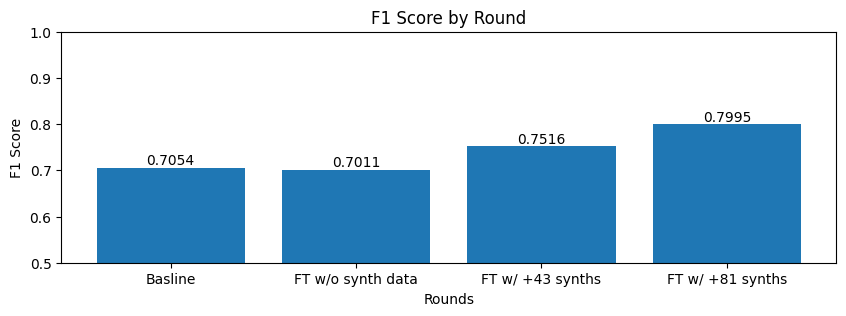

In [0]:
# baseline
baseline = {
    "true_positive": 267,
    "fale_negative": 21,
    "false_positive": 202,
    "true_negative": 10,
    "presicion": 0.5693,
    "recall": 0.9271,
    "f1_score": 0.7054,
}

# no synth
round_0 = {
    "true_positive": 265,
    "fale_negative": 50,
    "false_positive": 176,
    "true_negative": 9,
    "presicion": 0.6009,
    "recall": 0.8413,
    "f1_score": 0.7011,
}

# 43 synths
round_1 = {
    "true_positive": 301,
    "fale_negative": 10,
    "false_positive": 189,
    "true_negative": 0,
    "presicion": 0.6143,
    "recall": 0.9678,
    "f1_score": 0.7516,
}

# 83 synths
round_2 = {
    "true_positive": 327,
    "fale_negative": 2,
    "false_positive": 162,
    "true_negative": 9,
    "presicion": 0.6687,
    "recall": 0.9939,
    "f1_score": 0.7995,
}

import matplotlib.pyplot as plt

# Data
rounds = ["Basline", "FT w/o synth data", "FT w/ +43 synths", "FT w/ +81 synths"]
f1_scores = [0.7054, 0.7011, 0.7516, 0.7995]

# Create bar chart
plt.figure(figsize=(10, 3))
bars = plt.bar(rounds, f1_scores)
plt.xlabel("Rounds")
plt.ylabel("F1 Score")
plt.title("F1 Score by Round")
plt.ylim(0.5, 1)

# Add numbers to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 4),
        ha="center",
        va="bottom",
    )

plt.show()